# Introduction
Main objective of this project is to compare different supervised learning methods to increase performance of AI classifying model.<br>
I chose X (Twitter) posts dataset from Kaggle to extract modern language vocabulary.<br>
#### This project includes:
- Analyzing and visualizing significant information from X posts.
- Preprocessing text data.
- Creating AI model that predicts sentiment from given sentence.
- Comparison and reflection on each model variant.
#### Chapters:
1. Dataset overview
2. Processing text data
    1) Removing duplicates
    2) Balancing the data
    3) Length of sentences
3. Creating the Model
    1) Class weighting
    2) Text tokenizing
    3) Training the model
    4) Hyperparameter tuning
    5) Testing in practice
4. Conclusion

# I - Dataset overview
Checking the character of dataset and looking for any significant clues that could be used later on.

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('tweets.csv', index_col=0)
df

,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347
3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,negative,0.954023,anger,0.983203
4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124
...,...,...,...,...,...,...,...,...
24965,2022-01-01 02:02:04+00:00,1477097760931336198,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,Eodart,negative,0.682981,anger,0.906309
24966,2022-01-01 01:57:34+00:00,1477096631300415496,@kite_real @GamersNexus @Dell I didn't really ...,Eodart,positive,0.743940,joy,0.951701
24967,2022-01-01 01:36:36+00:00,1477091355629432833,Hey @JoshTheFixer here it is....27 4K UHD USB-...,Corleone250,neutral,0.654463,anticipation,0.471185
24968,2022-01-01 01:31:30+00:00,1477090070830141442,@bravadogaming @thewolfpena @Alienware @intel ...,MrTwistyyy,neutral,0.794049,anticipation,0.747014


Since we want to predict just the sentiment form text data,<br>
I decided to throw all unnecessary columns, leaving only 'text' and 'sentiment'.

In [29]:
df.drop(['Datetime', 'Tweet Id', 'Username', 'sentiment_score', 'emotion', 'emotion_score'], axis=1, inplace=True)
df.rename(columns={'Text': 'text', 'sentiment': 'label'}, inplace=True)

labels = {
    'negative': 0,
    'neutral': 1,
    'positive': 2,
}

df['label'] = df['label'].apply(lambda x: labels[x])
df

,text,label
0,@Logitech @apple @Google @Microsoft @Dell @Len...,1
1,@MK_habit_addict @official_stier @MortalKombat...,1
2,"As @CRN celebrates its 40th anniversary, Bob F...",2
3,@dell your customer service is horrible especi...,0
4,@zacokalo @Dell @DellCares @Dell give the man ...,1
...,...,...
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,0
24966,@kite_real @GamersNexus @Dell I didn't really ...,2
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,1
24968,@bravadogaming @thewolfpena @Alienware @intel ...,1


# II - Processing text data
#### Step 1 - Removing duplicates
The main problems with duplicates:
1) Duplicated sentences can lead to label favoritism. <br>
2) One sentence may contain 2 different labels,<br>
with that we can't really tell which one is the correct one.

In [30]:
df.isna().sum()

text     0
label    0
dtype: int64

In [31]:
df.duplicated().sum()

331

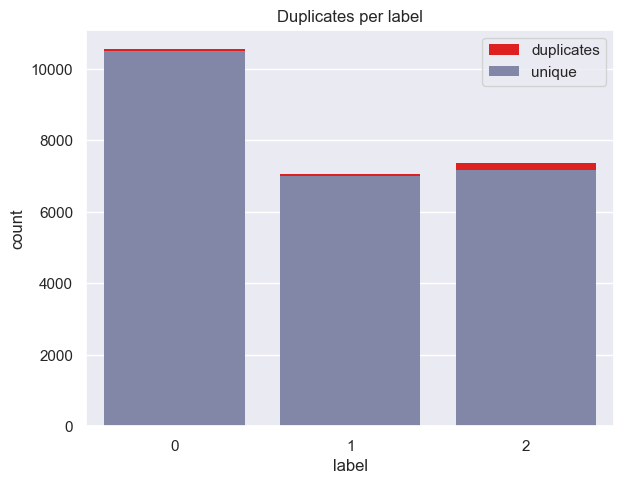

In [32]:
from copy import deepcopy

sns.set(style="darkgrid")
NAVY_LIGHT = '#4B527E'
NAVY_DARK = '#7C81AD'

# For better plot visualisation I saved duplicates  in second data frame
df_duplicates = deepcopy(df)
df.drop_duplicates(subset='text', keep='first', inplace=True)

fig = plt.figure()
fig = sns.countplot(df_duplicates, x='label', color='red', linewidth=0)
fig = sns.countplot(df, x='label', color=NAVY_DARK, linewidth=0)

plt.tight_layout()
plt.title('Duplicates per label')
plt.legend(['duplicates', 'unique'])

In [33]:
df.duplicated('text').sum()

0

#### Step 2 - Balancing the classes
The balance between each label seems a little incohesive especially if we look at the first column that stand out of the rest.<br>
We downsample the classes 0 and 2 to the smallest one which is 1.<br><br>
By undersampling classes we get rid of unbalanced data problem by the cost of less data for training the model.

In [34]:
df.value_counts('label')

label
0    10483
2     7167
1     6989
Name: count, dtype: int64

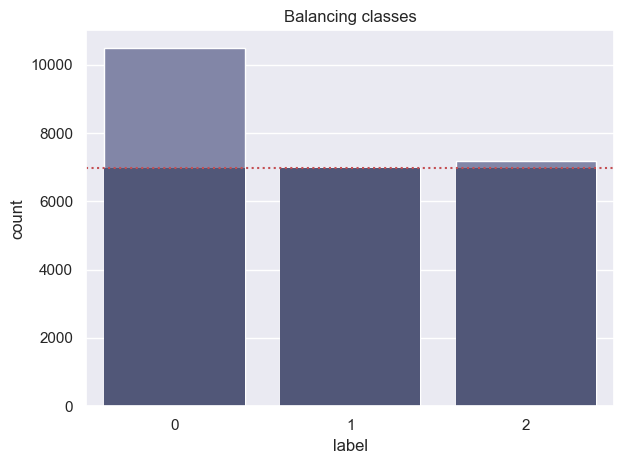

In [35]:
from sklearn.utils import resample

df_by_label = lambda i: df[df['label'] == i]
downsampled_df = pd.DataFrame(data=df_by_label(1))
max_size = len(df_by_label(1))

for i in [0, 2]:
    downsampled_class = resample(df_by_label(i),
                                 replace=True,
                                 n_samples=max_size,
                                 random_state=42)
    downsampled_df = pd.concat([downsampled_df, downsampled_class])

fig = plt.figure()

fig = sns.countplot(df, x='label', color=NAVY_DARK)

fig = sns.countplot(downsampled_df, x='label', color=NAVY_LIGHT, linewidth=0)
fig.axhline(y=max_size, color='r', linestyle=':')
fig.set_title('Balancing classes')

plt.tight_layout()
plt.show()

#### Step 3 - Length of sentences
By grouping sentences based on their length in words, we can identify and exclude groups with specific length that occurs less than 100 times in the dataset.<br>
Basically, we remove sentences that are shorter than 3 words and longer than 55 words to achieve even more balanced dataset.<br><br>
What I found intrestingly odd is that big jump in second plot in negative class at around 46 length.<br>
**Seems like negative sentences tend to be longer** but this clue is too small to be taken seriously.<br>
More safely we can deduce that negative class contain more long sentences.

                Mean: 26
       Harmonic mean: 16


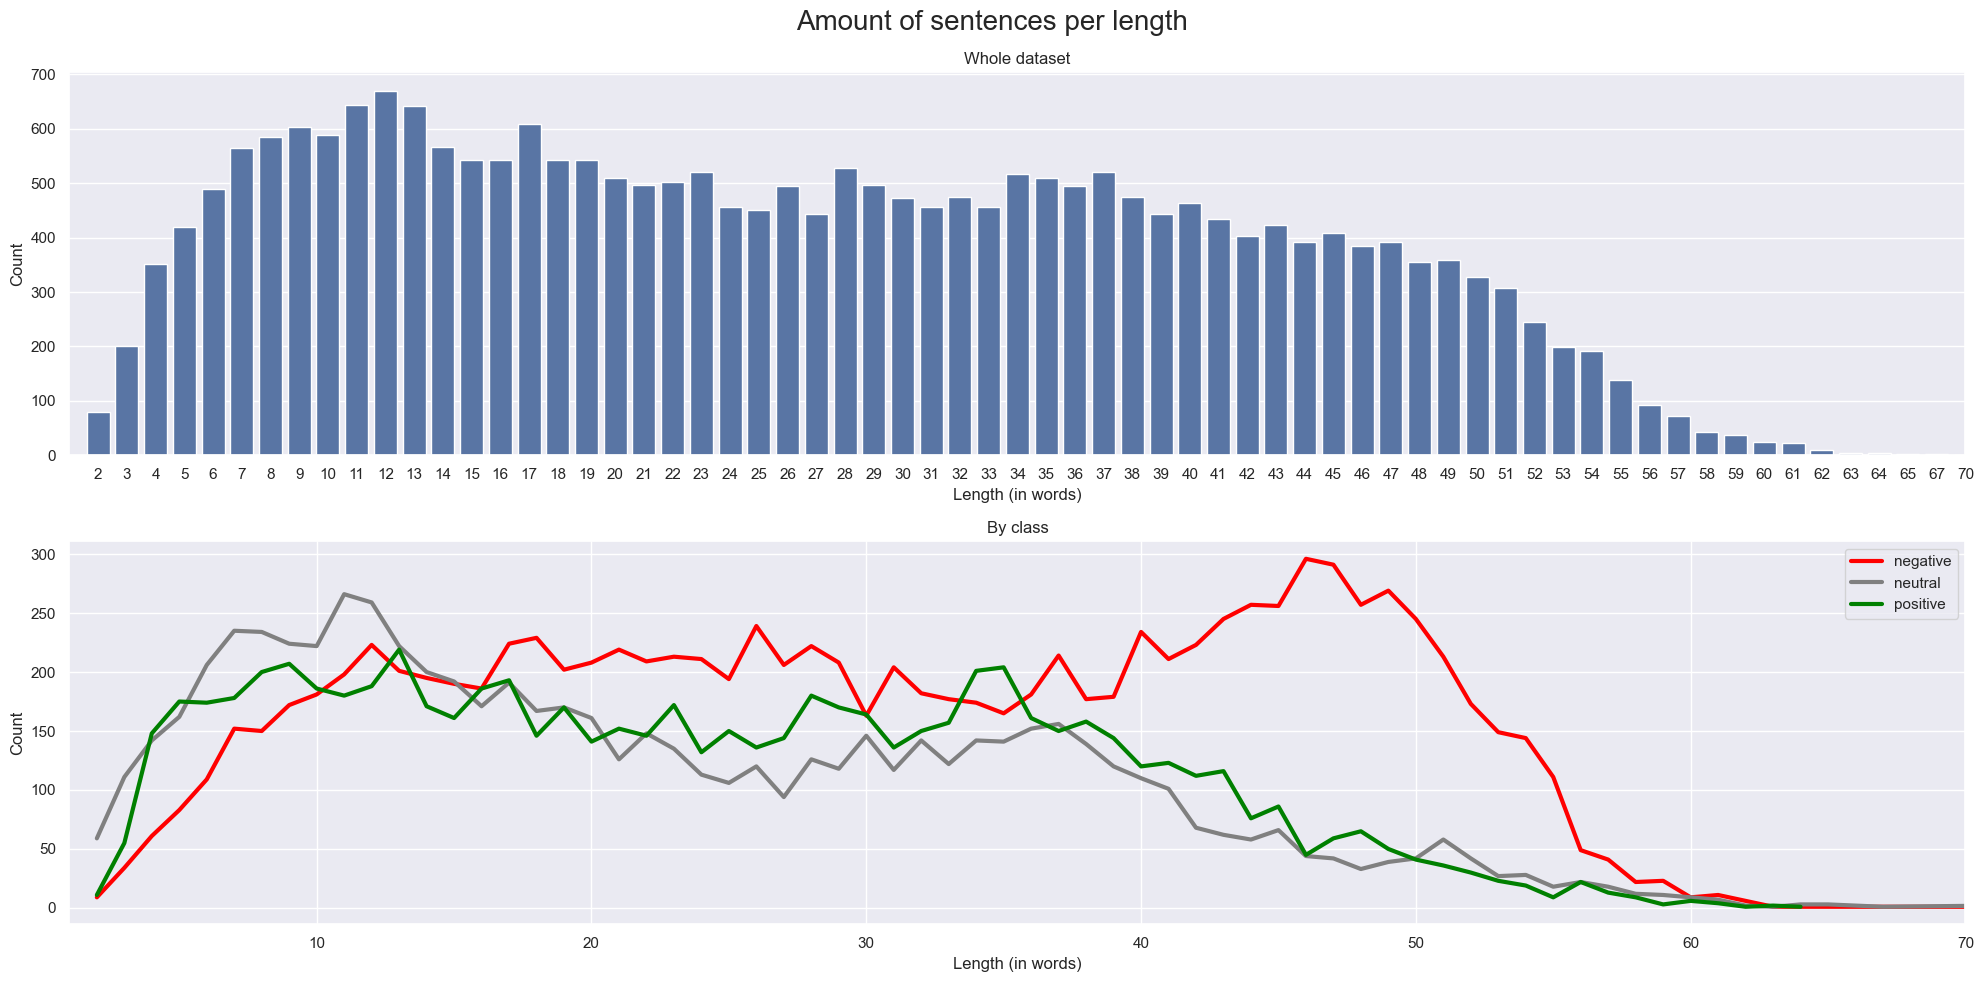

In [36]:
from matplotlib.lines import Line2D
from scipy.stats import hmean

df['length'] = df['text'].apply(lambda x: len(x.split()))
downsampled_df['length'] = downsampled_df['text'].apply(lambda x: len(x.split()))
df_by_label = lambda x: df[df['label'] == x]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.countplot(df, x='length', ax=axes[0])

colors = ['red', 'grey', 'green']

for i, color in enumerate(colors):
    count_by_length = df_by_label(i)['length'].value_counts().sort_index()
    sns.lineplot(x=count_by_length.index, y=count_by_length.values, marker=None, color=color, linewidth=3, ax=axes[1])

axes[0].set_title('Whole dataset')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Length (in words)')
axes[0].set_xlim(-1, 65)

axes[1].set_title('By class')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Length (in words)')
axes[1].set_xlim(1, 70)

legend_labels = ['negative', 'neutral', 'positive']
custom_lines = [Line2D([0], [0], color=colors[i], lw=3) for i in range(len(colors))]
axes[1].legend(custom_lines, legend_labels)

print(f"{'Mean':>20}: {int(df['length'].mean())}\n"
      f"{'Harmonic mean':>20}: {int(hmean(df['length']))}")

fig.suptitle('Amount of sentences per length', fontsize=20)
plt.tight_layout()
plt.show()

                Mean: 26
       Harmonic mean: 16


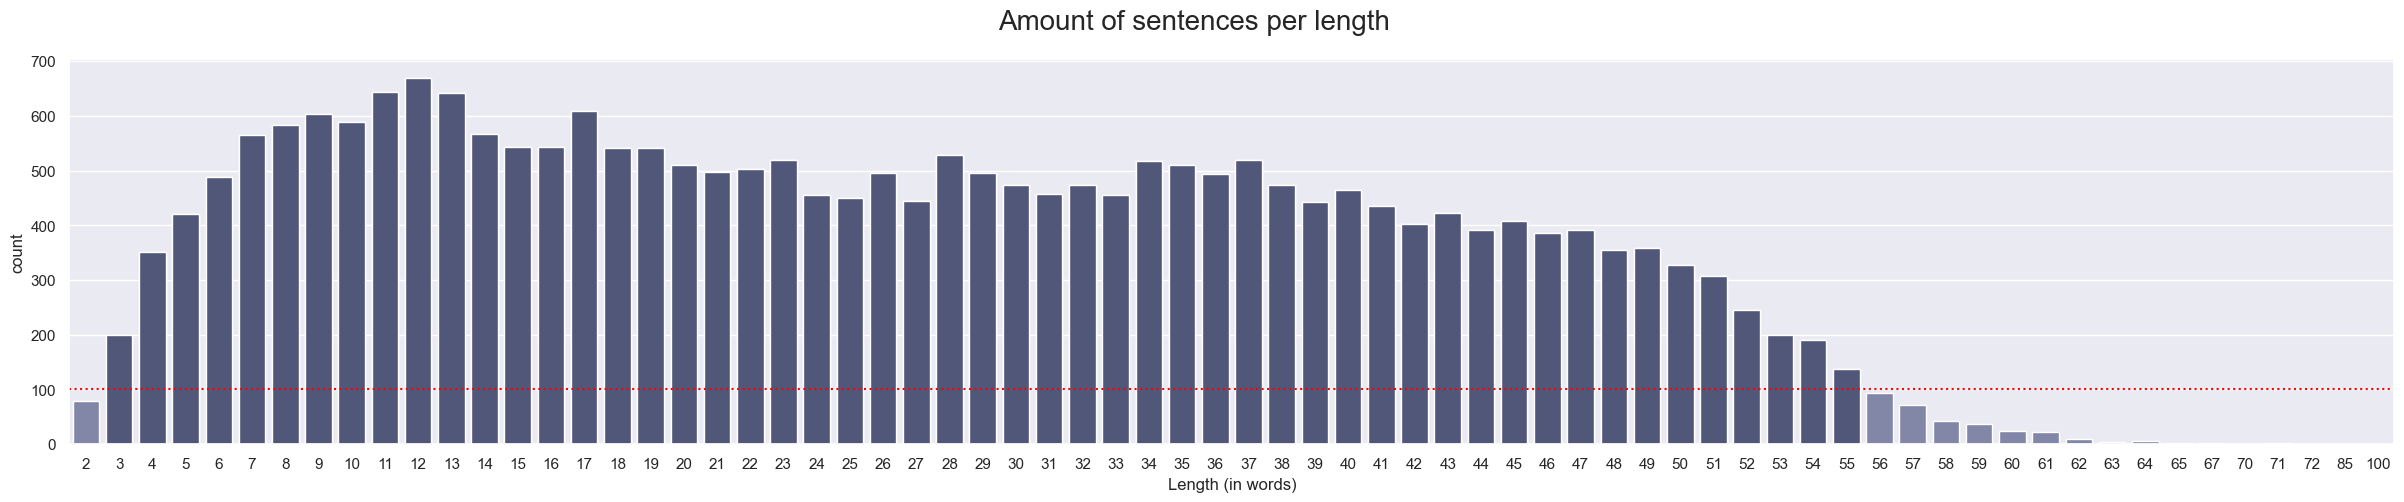

In [37]:
downsampled_df['length'] = df['text'].apply(lambda x: len(x.split()))

df_cut = df[(df['length'] >= 3) & (df['length'] <= 55)]
downsampled_df = downsampled_df[(downsampled_df['length'] >= 3) & (downsampled_df['length'] <= 55)]

min_count = len(df[df['length'] == 100])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 5))
sns.countplot(df, x='length', color=NAVY_DARK)
sns.countplot(df_cut, x='length', color=NAVY_LIGHT)

plt.axhline(y=100, color='red', linestyle=':')

print(f"{"Mean":>20}: {int(df['length'].mean())}\n"
      f"{"Harmonic mean":>20}: {int(hmean(df['length']))}")

fig.suptitle('Amount of sentences per length', fontsize=20)
axes.set_xlabel('Length (in words)')
plt.show()

df = df_cut

# III Creating the Model
#### Step 1 - Class weighting
First we have to prepare weights of our classes from unbalanced dataset to avoid label favoritism.

In [38]:
weights = dict()
for i in range(3):
    weights[i] = len(df) / len(df[df['label'] == i]) * 6
weights

{0: 14.108060917644776, 1: 21.275599765944996, 2: 20.49894291754757}

#### Step 2 - Text tokenizing
To give our model more clear understanding of text data, we tokenize it.<br>
With custom function we have more possibilities such as: removing emojis and mentions ('@username').

In [39]:
from sklearn.feature_extraction.text import BaseEstimator, TransformerMixin, TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import emoji

class TextTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, emoji=True, mentions=True):
        self.stemmer = SnowballStemmer('english')
        self.emoji = emoji
        self.mentions = mentions
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        processed_text = []
        
        for text in X:
            if self.emoji:
                text = emoji.demojize(text, delimiters=("", " "))
                text = text.replace("_", " ")
            if self.mentions:
                text = ' '.join(word for word in text.split() if word[0] != '@')
            text = ''.join(char.lower() for char in text if char not in punctuation)
            tokens = ' '.join(self.stemmer.stem(word) for word in text.split())
            processed_text.append(tokens)
            
        return processed_text

Testing functionality of our function.

In [40]:
a = "😊😡   i don't care! #happy"
b = "smiling face emoji"
c = '@user23 thats #cRaZy!'

tokenizer = TextTokenizer()
for sentence in [a, b, c]:
    print(f"before: {sentence}\n after: {tokenizer.transform([sentence])}")
    print('')

before: 😊😡   i don't care! #happy
 after: ['smile face with smile eye enrag face i dont care happi']

before: smiling face emoji
 after: ['smile face emoji']

before: @user23 thats #cRaZy!
 after: ['that crazi']



#### Step 3 - Training the model
Splitting datasets for downsampled and unbalanced versions.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer

# TRAIN TEST SPLIT FOR DEFAULT DATA
x = df.iloc[:, 0]
y = df.iloc[:, 1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# TRAIN TEST SPLIT FOR DOWNSAMPLED DATA
x_2 = downsampled_df.iloc[:, 0]
y_2 = downsampled_df.iloc[:, 1]
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, test_size=0.2, random_state=42)

Now we create 3 variants with the same AI algorithm:
- Unbalanced
- Balanced
- Balanced + Custom function

In [42]:
sgd_ds_2 = Pipeline([
    ('tok', TextTokenizer()),
    ('vec', CountVectorizer(ngram_range=(1, 2), stop_words=stopwords.words('english'))),
    ('clf', SGDClassifier(random_state=42, n_jobs=-1, penalty='elasticnet', shuffle=False, max_iter=100_000,
                          loss='log_loss', learning_rate='adaptive', eta0=0.11, alpha=7e-05, epsilon=0.8)),
])

sgd = deepcopy(sgd_ds)
sgd.set_params(clf__class_weight=weights)

sgd_ds = deepcopy(sgd_ds_2)
sgd_ds.steps.remove(sgd_ds.steps[0])

In [45]:
sgd.fit(x_train, y_train)
pred_default = sgd.predict(x_test)

sgd_ds.fit(x_train_2, y_train_2)
pred_ds = sgd_ds.predict(x_test_2)

sgd_ds_2.fit(x_train_2, y_train_2)
pred_ds_2 = sgd_ds_2.predict(x_test_2)

#### Step 4 - Hyperparameter tuning
Using *Grid Search Cross Validation* method we test all possible parameter combinations and return the one that performs the best.

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'tok__emoji': [True, False],
    'tok__mentions': [True, False]
    # 'vec__ngram_range': [(1,1), (1,2), (2,3)],
    # 'clf__shuffle': [True, False],
    # 'clf__alpha': [n/1_000 for n in range(5, 15)],
    # 'clf__loss': ['hinge', 'log_loss', 'modified_huber', 'perceptron', 'huber', 'epsilon_insensitive'],
    # 'clf__penalty': ['elasticnet', 'l1', 'l2', None],
    # 'clf__learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],
    # 'clf__epsilon': [n/10 for n in range(11)],
    # 'clf__eta0': [n/100 for n in range(1, 51, 10)],
    # 'clf__l1_ratio': [n/10 for n in range(0, 11)]
}

gs_clf = GridSearchCV(sgd_ds_2, parameters, cv=5, n_jobs=-1, verbose=1)
gs_clf = gs_clf.fit(x_train_2, y_train_2)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

cross_score = pd.DataFrame(gs_clf.cv_results_)[['param_tok__emoji', 'param_tok__mentions', 'mean_test_score']]
cross_score

# n_fits = 5
# for k, v in parameters.items():
#     print(f"{k:>20}:", len(v))
#     n_fits *= len(v)
# 
# print('')
# print(f"{'total':>20}:", n_fits)

Unbalanced:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2064
           1       0.67      0.70      0.68      1374
           2       0.79      0.76      0.78      1410

    accuracy                           0.78      4848
   macro avg       0.77      0.77      0.77      4848
weighted avg       0.78      0.78      0.78      4848


Balanced:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1390
           1       0.77      0.77      0.77      1362
           2       0.86      0.86      0.86      1369

    accuracy                           0.83      4121
   macro avg       0.83      0.83      0.83      4121
weighted avg       0.83      0.83      0.83      4121

Balanced 2:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1390
           1       0.76      0.80      0.78      1362
           2       0.87      0.84      0

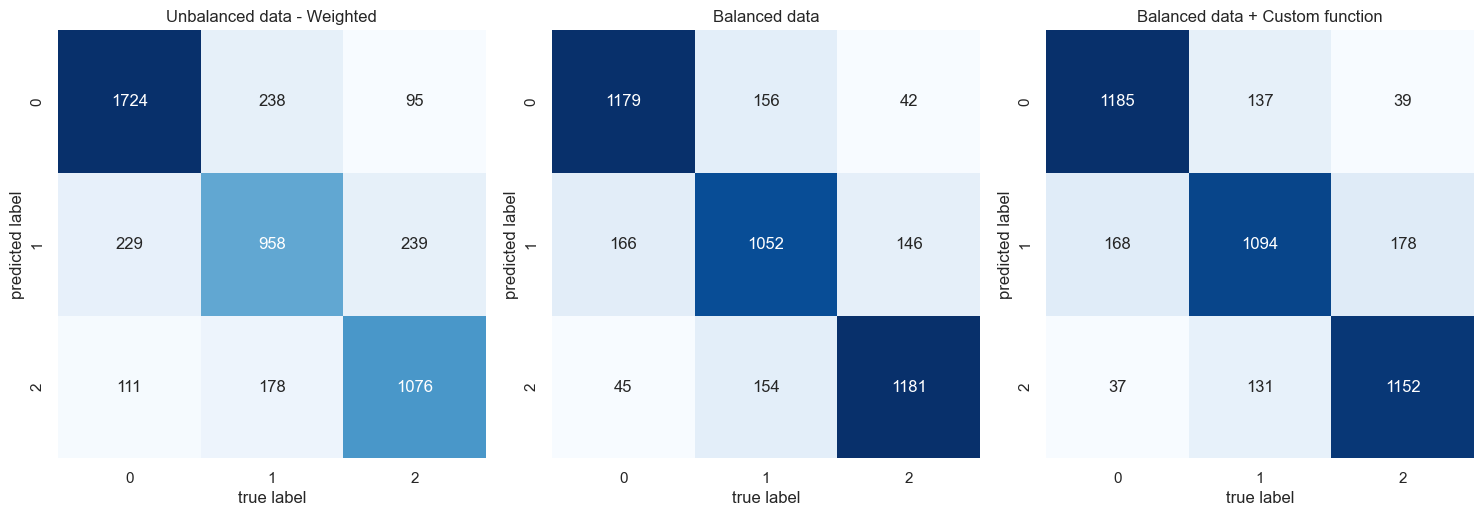

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

mat_original = confusion_matrix(y_test, pred_default)
sns.heatmap(mat_original.T, annot=True, fmt='d', square=True, cbar=False, cmap='Blues', ax=axes[0])

mat_downsampled = confusion_matrix(y_test_2, pred_ds)
sns.heatmap(mat_downsampled.T, annot=True, fmt='d', square=True, cbar=False, cmap='Blues', ax=axes[1])

mat_downsampled_2 = confusion_matrix(y_test_2, pred_ds_2)
sns.heatmap(mat_downsampled_2.T, annot=True, fmt='d', square=True, cbar=False, cmap='Blues', ax=axes[2])

axes[0].set_title('Unbalanced data - Weighted')
axes[1].set_title('Balanced data')
axes[2].set_title('Balanced data + Custom function')

for i in range(3):
    axes[i].set_xlabel('true label')
    axes[i].set_ylabel('predicted label')

print(f"Unbalanced:\n{classification_report(y_test, pred_default)}\n")
print(f"Balanced:\n{classification_report(y_test_2, pred_ds)}")
print(f"Balanced 2:\n{classification_report(y_test_2, pred_ds_2)}")

plt.tight_layout()
plt.show()

#### Step 5 - Testing in practice
For tests, I prepared 3 lists that coresponds to each sentiment,<br>
every list contains 10 sentences with ~5 words length and 10 sentences with ~10 words length.

In [75]:
negative_sentences = [
    # ~5 Words
    "I hate this so much. 😡",
    "Worst experience ever. 👎 #disappointed",
    "This is so frustrating. 😠",
    "Totally not worth it. 💸",
    "@user213 You ruined everything. 😤",
    "I can’t stand this. 😒",
    "This is pure garbage. 🚮",
    "Unbelievably bad service. 😤 #neveragain",
    "What a waste of time. 🕒",
    "Seriously the worst ever. ❌",

    # ~10 Words
    "I can't believe how awful this turned out to be. 😡 #fail",
    "@user213 You really let me down, very disappointed in you.",
    "This is the worst product I’ve ever purchased. Refund, please! 💸",
    "Completely ruined my day, thanks for nothing. 😠 #neveragain",
    "Everything about this is just terrible, never using it again. ❌",
    "@user213 Your customer support is useless and unhelpful, so frustrating! 😤",
    "Honestly, I expected much better from you, this is trash. 🚮",
    "Can’t believe I wasted money on this, so regretful. 💸",
    "I am so upset right now, what a huge letdown. 😡",
    "Honestly, this entire experience has been nothing but a headache. 😠"
]

neutral_sentences = [
    # ~5 Words
    "It was okay, nothing special. 🤷‍♂️",
    "Not good, not bad either.",
    "Just an average experience today.",
    "Meh, it’s alright I guess. 😐",
    "@user213 Could be better, honestly.",
    "This is neither here nor there.",
    "Just a regular day. 🤔",
    "I feel indifferent about it.",
    "Nothing to complain about. 🤷‍♀️",
    "It's fine, I suppose. 😶",

    # ~10 Words
    "I guess it’s just fine, nothing really stood out. 🤷‍♂️",
    "Not amazing, but not terrible either, just kind of average.",
    "@user213 It’s okay, not sure how I feel about it.",
    "This was pretty much what I expected, nothing surprising here.",
    "Honestly, I’m neither impressed nor disappointed, just neutral. 😐",
    "I don’t really have a strong opinion on this one.",
    "It’s fine, nothing to rave about or criticize. 🤷‍♀️",
    "Neither satisfied nor dissatisfied, just another average experience. 🤔",
    "@user213 It was pretty standard, nothing particularly great or bad.",
    "I’d call it a very average experience, to be honest. 😶"
]

positive_sentences = [
    # ~5 Words
    "Absolutely loved it! 😍 #amazing",
    "This made my day! 😊",
    "Fantastic job, @user213! 🌟",
    "I’m so happy! 🥳 #blessed",
    "Worth every penny! 💰",
    "Super excited about this! 😃",
    "Best decision ever made. 🙌",
    "Love this so much! 💖",
    "So proud of you, @user213!",
    "Can’t stop smiling! 😊",

    # ~10 Words
    "I’m incredibly happy with this, exceeded all my expectations! 😍",
    "Thank you, @user213, for such a fantastic experience! 🌟 #grateful",
    "This product has genuinely improved my life, super grateful! 💖",
    "I am over the moon with how this turned out. 😊",
    "Wow, just wow! Couldn’t have asked for anything better. 🙌",
    "Amazing experience from start to finish, highly recommend! 🌟 #bestdayever",
    "I’m so glad I tried this, totally worth it. 😊",
    "You nailed it, @user213! I’m really impressed! 👏",
    "I couldn’t be happier with the results, totally satisfied. 😃",
    "This exceeded my expectations, truly a delightful surprise! 🌟"
]

score_df = {
    'Model': ['Default', 'Downsampled', 'Downsampled + Custom Function'],
    'Sentiment': ['Negative', 'Neutral', 'Positive'],
    'Score': [0, 0, 0]

}
score_df = pd.DataFrame(score_df)
score_df = pd.pivot(data=score_df, index='Sentiment', columns='Model', values='Score')

for i_2, model in enumerate([sgd, sgd_ds, sgd_ds_2]):
    for i_1, sentiment in enumerate([negative_sentences, neutral_sentences, positive_sentences]):
        predictions = model.predict(sentiment)
        score = (np.array(predictions == i_1).sum() / 20) * 100
        score_df.iloc[i_1, i_2] = score
        print(score)

score_df

80.0
40.0
85.0
75.0
40.0
80.0
95.0
65.0
95.0


Model,Default,Downsampled,Downsampled + Custom Function
Sentiment,,,
Negative,80.0,75.0,95.0
Neutral,40.0,40.0,65.0
Positive,85.0,80.0,95.0


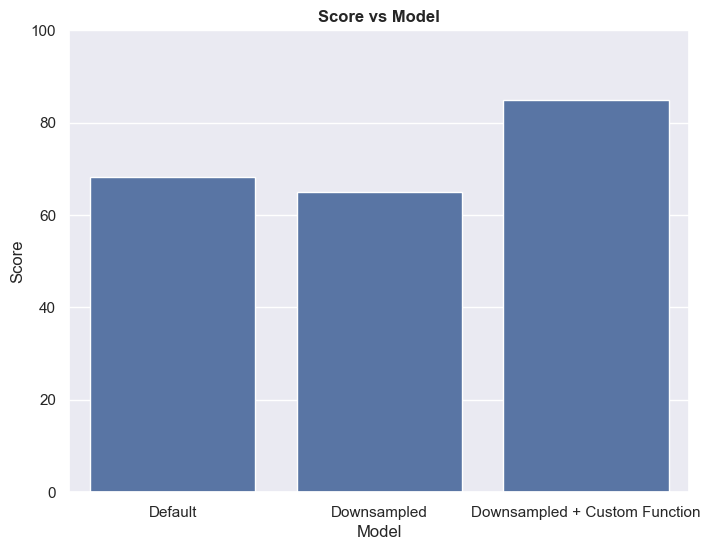

In [121]:
avg_score = score_df.mean(axis=0).round(1).reset_index()
avg_score.columns = ['Model', 'Score']
avg_score

fig = plt.figure(figsize=(8, 6))
fig = sns.barplot(data=avg_score, x='Model', y='Score')
fig.set_title('Score vs Model', fontweight='bold')
fig.set_ylim(0, 100)
plt.show()

# IV Conclusion
I've tried few different supervised algorithms such like: NaiveBayes, LinearRegression.<br>
However SGDClassifier returns with the highest score.<br>
I'm very satisfied with practical test results, the custom function works way better in practice. Probably due to emoji usage.<br>
I think it has potential to be used in social media websites such as: Instagram, Twitter or YouTube.<br><br>
#### Thank you for reading this project and I hope you enjoyed the whole process :]
_@ Gracjan Pawłowski 2024_